In [ ]:
# %%bash
# pip install pydicom opencv-python scikit-image
# pip install pyradiomics

In [1]:
import cv2 as cv
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pydicom as dicom
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk
from sklearn.neural_network import MLPClassifier

Cut images into 40x30 subimages

In [40]:
# Input and outputh directories
input_path = "imagens_ihq_er"
output_path = "imagens_cortadas"

# Create dir if it doesn't exist 
#os.makedirs(output_directory, exist_ok=True)

# Subimages size
new_width = 40
new_height = 30

n_images = 0

# Browse input path
for class_dir in os.listdir(input_path):
    class_path = os.path.join(input_path, class_dir)

    # If it is a directory 
    if os.path.isdir(class_path):     
        
        # Save image id
        image_id = 1
        
        # Go through images
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            
            # Save patient id
            patient = image_file.split("_")[0]                         
                 
            image = cv.imread(image_path)

            # If image exists
            if image is not None:
               
                # Save subimage id
                sub_id = 1
                
                for i in range(0, image.shape[0], new_height):
                    for j in range(0, image.shape[1], new_width):
                        
                        # Cut image into subimage
                        sub_image = image[i:i+new_height, j:j+new_width]

                        # Output file path
                        output_file = f"{patient}_img{image_id}-{sub_id}.png"                   
                        output_file = os.path.join(output_path, class_dir, output_file)                        
                      
                        # Save subimage
                        cv.imwrite(output_file, sub_image)                 

                        sub_id += 1
                        n_images += 1
                        
                image_id += 1   


If images are already cut, open them and save images, patients and classes/groups

In [91]:
# Input directory
input_path = "imagens_cortadas"

# Lists to save images, patients and classes
images = []
patients = []
classes = []

# Browse input path
for class_dir in os.listdir(input_path):
    class_path = os.path.join(input_path, class_dir)
    
    # If it is a directory 
    if os.path.isdir(class_path):    
      
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            
            patient = image_file.split("_")[0]             
                 
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            
            # Append image, patient id and class to list
            images.append(image)
            patients.append(patient)
            classes.append(class_dir)       

Divide images into 5 folds, in a way that the same patient stays in the same fold

In [92]:
# Create a list of unique indexes for patients
unique_patients = list(set(patients))

# Shuffle the list of unique indexes
random.shuffle(unique_patients)

# Divide patients into groups
n_folds = 4 # since it's not an exact division, there will be 5 folds
fold_size = len(unique_patients) // n_folds
patients_folds = [unique_patients[i:i+fold_size] for i in range(0, len(unique_patients), fold_size)]

# List to save folds
folds = []

# Divide images into folds based on patients
for i, patients_folds in enumerate(patients_folds):
    train_patients = [p for p in unique_patients if p not in patients_folds]
    test_patients = patients_folds
    
    train_indices = [i for i, patient in enumerate(patients) if patient in train_patients]
    test_indices = [i for i, patient in enumerate(patients) if patient in test_patients]
    
    train_images = [images[i] for i in train_indices]
    test_images = [images[i] for i in test_indices]
    train_classes = [classes[i] for i in train_indices]
    test_classes = [classes[i] for i in test_indices]
    
    folds.append((train_images, test_images, train_classes, test_classes))


Apply Otsu and Adaptative thresholds to all images

In [93]:
# For each fold
for i in range(len(folds)):
    fold = folds[i]
               
    x_train = fold[0]
    x_test = fold[1]
    y_train = fold[2]
    y_test = fold[3]
               
    x_train_otsu = []
    x_train_adapt = []
    x_test_otsu = []
    x_test_adapt = []
    
    # For each image in train                          
    for img in x_train: 
        
        # Otsu's thresholding
        _, th1 = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
        
        # Adaptative  gaussian thresholding        
        #th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
        th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
               
        x_train_otsu.append(th1)
        x_train_adapt.append(th3)
        
    # For each image in test 
    for img in x_test: 
        
        # Otsu's thresholding
        _, th1 = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
               
        # Adaptative  gaussian thresholding 
        #th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
        th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
               
        x_test_otsu.append(th1)
        x_test_adapt.append(th3)
        
    # Update list with the thresholds           
    folds[i] = (x_train, x_train_otsu, x_train_adapt, x_test, x_test_otsu, x_test_adapt, y_train, y_test)
    

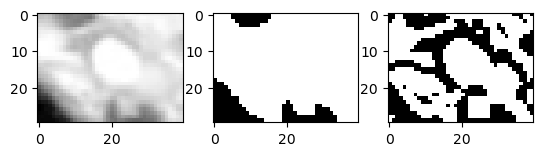

In [102]:
from matplotlib import pyplot as plt

plt.subplot(2, 3, 1),plt.imshow(folds[1][0][0],'gray')
plt.subplot(2, 3, 2),plt.imshow(folds[1][1][0],'gray')
plt.subplot(2, 3, 3),plt.imshow(folds[1][2][0],'gray')
plt.show()

In [ ]:
# Save folds
dump(folds, '../folds.joblib')

In [2]:
# Load folds
folds = load('../folds.joblib')

Extract features with PyRadiomics

In [3]:
params = 'Params.yaml'
settings = {'label': 255}
extractor = featureextractor.RadiomicsFeatureExtractor(params, additionalInfo=True, **settings)

In [ ]:
data_spacing=[1,1,1]
features_otsu = {}
features_adapt = {}

for i in range(len(folds)):
    
    fold = folds[i]
               
    x_train = fold[0]
    x_train_otsu = fold[1]
    x_train_adapt = fold[2]
    x_test = fold[3]
    x_test_otsu = fold[4]
    x_test_adapt = fold[5]
    y_train = fold[6]
    y_test = fold[7]
    
    df_train_otsu = pd.DataFrame()
    df_test_otsu = pd.DataFrame()
    df_train_adapt = pd.DataFrame()
    df_test_adapt = pd.DataFrame()
    
    for idx in range(len(x_train)): 
        
        train_img = x_train[idx]
        train_otsu = x_train_otsu[idx]
        train_adapt = x_train_adapt[idx]
        
        sitk_img = sitk.GetImageFromArray(train_img)
        sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_img = sitk.JoinSeries(sitk_img)

        sitk_otsu = sitk.GetImageFromArray(train_otsu)
        sitk_otsu.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_otsu = sitk.JoinSeries(sitk_otsu)
        sitk_otsu = sitk.Cast(sitk_otsu, sitk.sitkInt32)
        
        sitk_adapt = sitk.GetImageFromArray(train_adapt)
        sitk_adapt.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_adapt = sitk.JoinSeries(sitk_adapt)
        sitk_adapt = sitk.Cast(sitk_otsu, sitk.sitkInt32)
        
        features_otsu = extractor.execute(sitk_img, sitk_otsu)
        features_adapt = extractor.execute(sitk_img, sitk_adapt)
        
        # First image, 
        if i == 0: 
            names = list(features_otsu.keys())
            df_train_otsu.columns = names
            df_test_adapt.columns = names
            df_train_otsu.columns = names
            df_test_adapt.columns = names
            
    for idx in range(len(x_test)): 
        
        test_img = x_test[idx]
        test_otsu = x_test_otsu[idx]
        test_adapt = x_test_adapt[idx]
        
        sitk_img = sitk.GetImageFromArray(test_img)
        sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_img = sitk.JoinSeries(sitk_img)

        sitk_otsu = sitk.GetImageFromArray(test_otsu)
        sitk_otsu.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_otsu = sitk.JoinSeries(sitk_otsu)
        sitk_otsu = sitk.Cast(sitk_otsu, sitk.sitkInt32)
        
        sitk_adapt = sitk.GetImageFromArray(test_adapt)
        sitk_adapt.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_adapt = sitk.JoinSeries(sitk_adapt)
        sitk_adapt = sitk.Cast(sitk_otsu, sitk.sitkInt32)
        
        features_otsu = extractor.execute(sitk_img, sitk_otsu)
        features_adapt = extractor.execute(sitk_img, sitk_adapt)

    
    fold_id = i+1
    features_dict[fold_id] = (df_train_otsu, df_test_otsu, df_train_adapt, df_test_adapt, y_train, y_test)
    
    

30800
30800
30800
9200
9200
9200
30800
9200
30100
30100
30100
9900
9900
9900
30100
9900
28200
28200
28200
11800
11800
11800
28200
11800
31400
31400
31400
8600
8600
8600
31400
8600
39500
39500
39500
500
500
500
39500
500


In [14]:
test_img = folds[1][0][1]
otsu = folds[1][1][1]

In [15]:
data_spacing=[1,1,1]
sitk_img = sitk.GetImageFromArray(test_img)
sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
sitk_img = sitk.JoinSeries(sitk_img)

sitk_mask = sitk.GetImageFromArray(otsu)
sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
sitk_mask = sitk.JoinSeries(sitk_mask)
sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

In [22]:
# !wget -c https://raw.githubusercontent.com/AIM-Harvard/pyradiomics/master/examples/exampleSettings/Params.yaml

In [21]:
for key, val in enumerate(features):
    print(val, features[val])

diagnostics_Versions_PyRadiomics v3.1.0
diagnostics_Versions_Numpy 1.24.3
diagnostics_Versions_SimpleITK 2.3.0
diagnostics_Versions_PyWavelet 1.3.0
diagnostics_Versions_Python 3.9.13
diagnostics_Configuration_Settings {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 255, 'additionalInfo': True, 'binWidth': 25, 'weightingNorm': None}
diagnostics_Configuration_EnabledImageTypes {'Original': {}}
diagnostics_Image-original_Hash 62950cd7c8bb19d09dce061fc5529631343a5724
diagnostics_Image-original_Dimensionality 3D
diagnostics_Image-original_Spacing (1.0, 1.0, 1.0)
diagnostics_Image-original_Size (40, 30, 1)
diagnostics_Image-original_Mean 213.84333333333333
diagnostics_Image-original_Minimum 39.0
diagnostics_Image-original_Maximum 255.0
d